In [1]:
import os
os.chdir(os.path.split(os.getcwd())[0])

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from agent import *
from optionpricing import *
import yaml
import torch
from collections import defaultdict

In [3]:
import matplotlib.style as style
style.use('seaborn-poster')

In [7]:
def load_estimator(env, device, ngpu, experiment_folder, kind = 'best'):
    """
    env: option pricing environment
    device: torch device
    ngpu: number of gpu
    experiment_folder: name of experiment (as passed in --savedir)
    kind: model to load; options- best, checkpoint
    """
    state_shape = env.observation_space.shape
    state_space_dim = state_shape[0] if len(state_shape) == 1 else state_shape
    
    estimator = Estimator(device, ngpu, state_space_dim, env.action_space.n)
    if kind == 'best':
        checkpoint = torch.load(os.path.join('experiments', experiment_folder, 'best.pth'))
    elif kind == 'checkpoint':
        checkpoint = torch.load(os.path.join('experiments', experiment_folder, 'checkpoint.pth'))
    else:
        raise ValueError('Invalid choice for kind')
        
    estimator.load_state_dict(checkpoint['estimator'])
    estimator.eval()
    
    return estimator

In [49]:
def simulate_episode(env, device, estimator):
    state = torch.from_numpy(env.reset()).to(device)
    done = False
    
    history = defaultdict(list)
    
    while not done:
        history['delta'].append(env.delta)
        history['stock_value'].append(env.stock_value)
        history['option_value'].append(env.option_value)
        history['cash'].append(env.cash)
        
        with torch.no_grad():
            action = np.argmax(estimator(state).numpy())
        state, reward, done, info = env.step(action)
        
        history['reward'].append(reward)
        history['n'].append(env.n)
        try:
            history['stock_pnl'].append(history['stock_value'][-1] - history['stock_value'][-2])
            history['option_pnl'].append(history['option_value'][-1] + history['cash'][-1] - history['option_value'][-2] - history['cash'][-2])
            history['total_pnl'].append(history['stock_pnl'][-1] + history['option_pnl'][-1])
        except:
            pass
        
        state = torch.from_numpy(state).to(device)
        
    history['stock_pnl'].append(history['stock_value'][-1] - history['stock_value'][-2])
    history['option_pnl'].append(history['option_value'][-1] + history['cash'][-1] - history['option_value'][-2] - history['cash'][-2])
    history['total_pnl'].append(history['stock_pnl'][-1] + history['option_pnl'][-1])
    
    history = {k: np.array(v) for k, v in history.items()}
    
    return history

In [103]:
def cost_volatility_kde(env, device, estimator):
    pass

In [50]:
experiment_folder = 'Oct1_lr-high_ne-low_clip-inc'

In [51]:
config = {
        'S': 100,
        'T': 10, # 10 days
        'L': 1,
        'm': 100, # L options for m stocks
        'n': 0,
        'K': 100,
        'D': 5,
        'mu': 0,
        'sigma': 0.01,
        'r': 0,
        'ss': 5,
        'kappa': 0.1
        }

env = OptionPricingEnv()
env.configure(**config)

In [52]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ngpu = 1 if torch.cuda.is_available() else 0

In [53]:
state = env.reset()
init_stock_price = env.S

In [54]:
estimator = load_estimator(env, device, ngpu, experiment_folder, 'best')

In [102]:
history['stock_value'] + history['option_value'] + history['cash']

array([617.42124035, 602.74541741, 608.88737013, 601.66758555,
       616.30112813, 615.71395232, 612.6478562 , 614.857515  ,
       609.13970716, 608.82610069, 600.29811576, 613.62665745,
       607.01326708, 606.68402757, 607.89563901, 602.55588309,
       596.635481  , 598.78676321, 589.04072311, 589.70245403,
       582.88317843, 576.9487599 , 569.0906921 , 561.2036608 ,
       565.24956876, 569.1684496 , 557.52136376, 554.25110291,
       541.53498916, 541.07611091, 614.10026904, 601.09652723,
       592.7576045 , 629.81981765, 630.45934253, 624.22393946,
       633.8728524 , 629.72547006, 660.32604513, 650.04835075,
       726.19411688, 717.63143675, 704.49641332, 662.12826075,
       654.12995979, 637.05096128, 613.93332628, 578.87810415,
       578.36101633, 579.58686142])

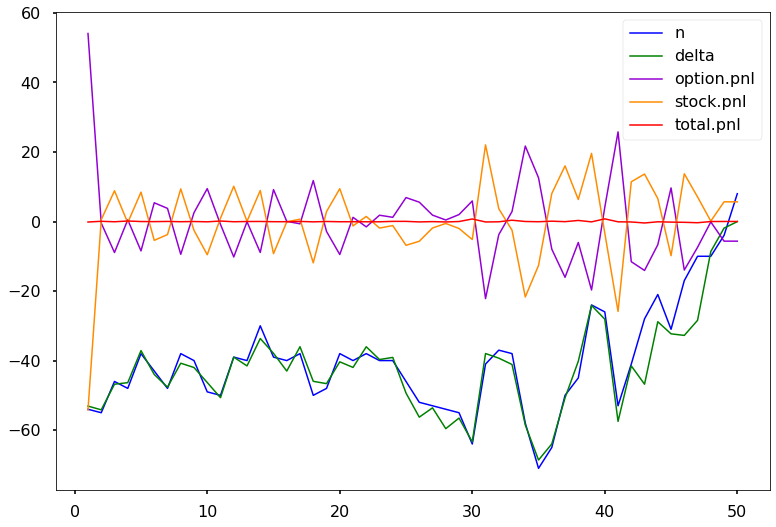

In [98]:
#history = simulate_episode(env, device, estimator)
steps = np.arange(1, len(history['delta']) + 1, 1)

fig, ax = plt.subplots()
ax.plot(steps, history['n'], color = 'blue', lw = 1.5, label = 'n')
ax.plot(steps, history['delta'] * -env.L * env.m, color = 'green', lw = 1.5, label = 'delta')
ax.plot(steps, history['option_pnl'] / init_stock_price, color = 'darkviolet', lw = 1.5, label = 'option.pnl')
ax.plot(steps, history['stock_pnl'] / init_stock_price, color = 'darkorange', lw = 1.5, label = 'stock.pnl')
ax.plot(steps, history['total_pnl'] / init_stock_price, color = 'red', lw = 1.5, label = 'total.pnl')
plt.legend()
plt.show()

In [64]:
for k, v in history.items():
    print(f'{k}: {len(v)}')

delta: 50
stock_value: 50
option_value: 50
cash: 50
reward: 50
n: 50
stock_pnl: 50
option_pnl: 50
total_pnl: 50
